<div >
<img src = "banner.jpg" />
</div>

# The Bootstrap

<div >
<img src = "pelos.jpg" />
</div>


## Introduction


The bootstrap is a widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method. As a simple example, the bootstrap can be used to estimate the standard errors of the coefficients from a linear regression fit. In the specific case of linear regression, this is not particularly useful, since standard statistical software outputs such standard errors automatically. However, the power of the bootstrap lies in the fact that it can be easily applied to a wide range of statistical learning methods, including some for which a measure of variability is otherwise difficult to obtain and is not automatically output by statistical software.

Let's ilustrate with an example. Suppose we have the following data

In [1]:
    gas<-read.csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/gas.csv",header=T)
    head(gas)

,consumption,price,income
,<dbl>,<dbl>,<dbl>
1,5.090526,-1.602419,2.342972
2,5.092324,-1.572913,2.317068
3,5.093950,-1.547504,2.340076
4,5.067488,-1.505120,2.323478
5,5.049762,-1.456725,2.335196
6,5.049566,-1.438641,2.364967


## Case 1

Where all the variables are in logs, and would like to estimate an equation like this: 

$$\ln{Quantity}_{t}= \alpha + \beta_1 \ln{Price}_{t} +\beta_2 \ln{Income}_{t} +u_{t}$$

In [2]:
require("pacman")
p_load("tidyverse","stargazer")
mod1<- lm(consumption~price+income,gas)
stargazer(mod1,type="text")

Loading required package: pacman




                        Dependent variable:    
                    ---------------------------
                            consumption        
-----------------------------------------------
price                        -0.838***         
                              (0.025)          
                                               
income                       2.117***          
                              (0.048)          
                                               
Constant                     -1.056***         
                              (0.158)          
                                               
-----------------------------------------------
Observations                    246            
R2                             0.917           
Adjusted R2                    0.917           
Residual Std. Error      0.093 (df = 243)      
F Statistic         1,345.711*** (df = 2; 243) 
Note:               *p<0.1; **p<0.05; ***p<0.01


In [3]:
set.seed(112)

R<-1000 # Number of Repetions()

eta_mod1<-rep(0,R)


In [4]:
for (i in 1:R){
        
      db_sample<- sample_frac(gas,size=1,replace=TRUE)
        
      f<-lm(consumption~price+income,db_sample)

      coefs<-f$coefficients
    
      eta_mod1[i]<-coefs[2]
    }

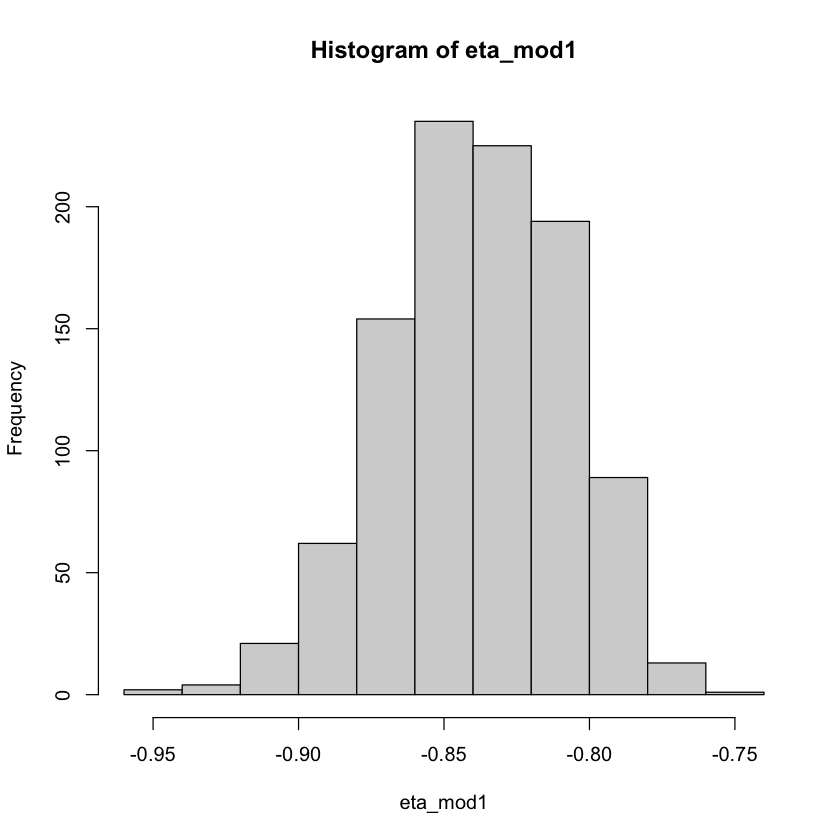

In [5]:
plot(hist(eta_mod1))

In [6]:
mean(eta_mod1)

[1] -0.838806

In [7]:
quantile(eta_mod1,c(0.025,0.975))

2.5%      97.5% 
-0.9005080 -0.7847117

In [8]:
sqrt(var(eta_mod1))

[1] 0.03065554

In [9]:
p_load("boot")



eta.fn<-function(data,index){
  coef(lm(consumption~price+income, data = data, subset = index))
}

boot(gas, eta.fn, R = 1000)

Loading required package: boot




ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = gas, statistic = eta.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* -1.0561479 -0.0009187600  0.16461905
t2* -0.8383634 -0.0002694841  0.03124188
t3*  2.1168926  0.0003579002  0.04930815

## Case 2

$$\ln{Quantity}_{t}= \alpha + \beta_1 \ln{Price}_{t}  + \beta_2 \ln{Price}^2_{t} +\beta_3 \ln{Income}_{t}+ \beta_4 \ln{Price}_{t}\times \ln{Income}_{t} +u_{t}$$




first you need first to generate the quadratic and other terms as follows: 

In [10]:
  gas<- gas %>% mutate(price2=price^2, 
                         price_income=price*income )

then regress: 

In [18]:
mod2<-lm(consumption~price+price2+income+price_income,gas)
stargazer(mod1,mod2,type="text")


                                     Dependent variable:                 
                    -----------------------------------------------------
                                         consumption                     
                               (1)                        (2)            
-------------------------------------------------------------------------
price                       -0.838***                  -1.783***         
                             (0.025)                    (0.141)          
                                                                         
price2                                                 -0.299***         
                                                        (0.021)          
                                                                         
income                       2.117***                   1.973***         
                             (0.048)                    (0.041)          
                                     

 To do that you will need to: 
 
i) Obtain the coefficients of regression: 

In [12]:
    coefs<-mod2$coef
    coefs 

(Intercept)        price       price2       income price_income 
  -0.5081995   -1.7825417   -0.2986801    1.9734354    0.2788964

ii) Extract the coefficients to scalars: 

In [13]:
    b0<-coefs[1] 
    b1<-coefs[2]
    b2<-coefs[3] 
    b3<-coefs[4]
    b4<-coefs[5] 

iii) Calculate the elasticity at the sample mean:

In [14]:
price_bar<-mean(gas$price)
income_bar<-mean(gas$income)


elastpt<-b1+2*b2*price_bar+b4*income_bar
    
elastpt

price 
-0.671777

How do we calculate the standard errors?


In [22]:

eta_mod2.fn<-function(data,index,
                      price_bar=mean(gas$price),
                      income_bar=mean(gas$income)){
      
      f<-lm(consumption~price+price2+income+price_income,data, subset = index)
        coefs<-f$coefficients
        
        b1<-coefs[2]
        b2<-coefs[3] 
        b4<-coefs[5] 
    
      elastpt<-b1+2*b2*price_bar+b4*income_bar
    
    
      return(elastpt)
    }

eta_mod2.fn(gas,1:nrow(gas))

    

price 
-0.671777

In [23]:
results <- boot(data=gas, eta_mod2.fn,R=1000)
results


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = gas, statistic = eta_mod2.fn, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* -0.671777 0.0004630156  0.01541431